In [36]:
import pandas as pd
import numpy as np 
import seaborn as sns
from helpers2 import S3Connection
import helpers2 
import matplotlib.pyplot as plt
import stat


In [37]:
df2019 = pd.read_csv('final2019.csv')
df2020 = pd.read_csv('final2020.csv')
df2021 = pd.read_csv('final2021.csv')
df2022 = pd.read_csv('final2022.csv')
df2023 = pd.read_csv('final2023.csv')

/tmp/ipykernel_10578/795601092.py:1: DtypeWarning: Columns (7,8,20,22,24,26,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df2019 = pd.read_csv('final2019.csv')
/tmp/ipykernel_10578/795601092.py:2: DtypeWarning: Columns (7,8,20,22,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df2020 = pd.read_csv('final2020.csv')
/tmp/ipykernel_10578/795601092.py:3: DtypeWarning: Columns (7,8,20,22,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df2021 = pd.read_csv('final2021.csv')
/tmp/ipykernel_10578/795601092.py:4: DtypeWarning: Columns (7,8,20,22,24,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df2022 = pd.read_csv('final2022.csv')
/tmp/ipykernel_10578/795601092.py:5: DtypeWarning: Columns (7,8,20,22,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df2023 = pd.read_csv('final2023.csv')


In [38]:
df = pd.concat([df2019, df2020, df2021, df2022, df2023], ignore_index=True)

In [39]:
print(df2019.columns)

Index(['Date_établissement_DPE', 'Etiquette_DPE', 'Type_bâtiment',
       'Année_construction', 'Période_construction',
       'Surface_habitable_logement', 'Adresse_(BAN)', 'N°_département_(BAN)',
       'Code_INSEE_(BAN)', 'Adresse_Normalisee', 'id_mutation',
       'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',
       'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_natu

In [40]:
def analyser_match(matching3):
    couleurs_dpe = {
        "A": "#006400",  # vert foncé
        "B": "#228B22",  # vert
        "C": "#7CFC00",  # vert clair
        "D": "#FFD700",  # jaune
        "E": "#FFA500",  # orange clair
        "F": "#FF8C00",  # orange
        "G": "#FF0000",  # rouge
    }

    # --- Statistiques de base ---
    print("Nombre de lignes :", len(matching3))
    total_nan = matching3.isna().sum().sum()
    print(f"Nombre total de NaN : {total_nan}")
    top_10_nan_colonnes = matching3.isna().sum().sort_values(ascending=False).head(10)
    print("Top 10 colonnes avec le plus de NaN :\n", top_10_nan_colonnes)

    # --- Histogramme DPE général ---
    dpe_counts = matching3["Etiquette_DPE"].value_counts(normalize=True) * 100
    dpe_counts = dpe_counts.reindex(["A", "B", "C", "D", "E", "F", "G"])  # ordre standard

    colors = [couleurs_dpe.get(dpe, "grey") for dpe in dpe_counts.index]

    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(dpe_counts.index, dpe_counts.values, color=colors, width=0.6)
    ax.set_title("Répartition des étiquettes DPE", fontsize=14)
    ax.set_xlabel("Étiquette DPE", fontsize=12)
    ax.set_ylabel("Pourcentage", fontsize=12)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.2f}%", ha='center', fontsize=10)
    plt.show()

    # --- Analyse départementale ---
    matching3["N°_département_(BAN)"] = pd.to_numeric(matching3["N°_département_(BAN)"], errors="coerce")
    match3_filtre101 = matching3[matching3["N°_département_(BAN)"] <= 101]
    match3_filtre101["N°_département_(BAN)"] = match3_filtre101["N°_département_(BAN)"].astype(int).astype(str).str.zfill(2)

    resultat = match3_filtre101.groupby("N°_département_(BAN)")["Etiquette_DPE"].value_counts(normalize=True).unstack() * 100
    pd.options.display.float_format = "{:.2f}%".format
    print("Répartition des DPE par département :\n", resultat)

    logements_A = match3_filtre101[match3_filtre101["Etiquette_DPE"] == "A"]
    logements_G = match3_filtre101[match3_filtre101["Etiquette_DPE"] == "G"]
    dep_max_A = logements_A["N°_département_(BAN)"].value_counts().idxmax()
    dep_max_G = logements_G["N°_département_(BAN)"].value_counts().idxmax()
    print(f"Département avec le plus de logements en A : {dep_max_A}")
    print(f"Département avec le plus de logements en G : {dep_max_G}")

    for dep in ["75", "92", "13", "44"]:
        if dep in resultat.index:
            plt.figure()
            dpe_values = resultat.loc[dep].reindex(["A", "B", "C", "D", "E", "F", "G"])
            colors_dep = [couleurs_dpe.get(label, "grey") for label in dpe_values.index]
            bars = plt.bar(dpe_values.index, dpe_values.values, color=colors_dep)
            plt.title(f"DPE - Département {dep}")
            plt.ylabel("Pourcentage")
            plt.xlabel("Étiquette DPE")
            for i, v in enumerate(dpe_values):
                plt.text(i, v + 0.5, f"{v:.2f}%", ha='center')
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

    # --- Analyse par type de bâtiment ---
    print("\nTypes de bâtiments présents :\n", matching3['Type_bâtiment'].value_counts())
    repartition_batiment = matching3['Type_bâtiment'].value_counts()
    plt.figure(figsize=(5, 5))
    plt.pie(repartition_batiment, labels=repartition_batiment.index, autopct='%1.1f%%', startangle=90, colors=['blue', 'skyblue', 'darkblue'])
    plt.title("Répartition par type de bâtiment")
    plt.axis('equal')
    plt.show()

    resultat_batiment = matching3.groupby(['Type_bâtiment', 'Etiquette_DPE']).size().unstack(fill_value=0)
    resultat_batiment_percentage = (resultat_batiment.T / resultat_batiment.sum(axis=1)).T * 100
    print("Pourcentage d'étiquettes DPE par type de bâtiment :\n", resultat_batiment_percentage)

    max_A_batiment = matching3[matching3["Etiquette_DPE"] == "A"]["Type_bâtiment"].value_counts().idxmax()
    max_E_batiment = matching3[matching3["Etiquette_DPE"] == "E"]["Type_bâtiment"].value_counts().idxmax()
    print(f"Type de bâtiment avec le plus de logements en A : {max_A_batiment}")
    print(f"Type de bâtiment avec le plus de logements en E : {max_E_batiment}")

    types_batiment = ['appartement', 'maison']
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    for i, t in enumerate(types_batiment):
        if t in resultat_batiment_percentage.index:
            data = resultat_batiment_percentage.loc[t].reindex(["A", "B", "C", "D", "E", "F", "G"])
            colors_bat = [couleurs_dpe.get(dpe, "grey") for dpe in data.index]
            bars = axes[i].bar(data.index, data.values, color=colors_bat)
            axes[i].set_title(f"{t.capitalize()} - Répartition DPE")
            axes[i].set_xlabel("Étiquette DPE")
            axes[i].set_ylabel("Pourcentage")
            for bar in bars:
                height = bar.get_height()
                axes[i].text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.2f}%", ha='center')
    plt.tight_layout()
    plt.show()

    # --- Analyse valeur foncière ---
    print(matching3['valeur_fonciere'])

    matching3['Valeur fonciere (num)'] = (
        matching3['valeur_fonciere']
        .astype(str)
        .str.replace(',', '.', regex=False)
    )
    matching3['Valeur fonciere (num)'] = pd.to_numeric(matching3['Valeur fonciere (num)'], errors='coerce')
    matching3_clean = matching3[matching3['Valeur fonciere (num)'].notna()]

    mean_value = matching3_clean['Valeur fonciere (num)'].mean()
    std_value = matching3_clean['Valeur fonciere (num)'].std()
    var_value = matching3_clean['Valeur fonciere (num)'].var()
    print(f"Moyenne : {mean_value:,.2f} €")
    print(f"Écart type : {std_value:,.2f} €")
    print(f"Variance : {var_value:,.2f} €²")

    plt.figure(figsize=(10, 5))
    sns.histplot(matching3_clean['Valeur fonciere (num)'] / 10_000, bins=500, kde=True)
    plt.xlim(0, matching3_clean['Valeur fonciere (num)'].quantile(0.99) / 10_000)
    plt.xticks(
        range(0, int(matching3_clean['Valeur fonciere (num)'].quantile(0.99) / 10_000) + 1, 8)
    )
    plt.xlabel("Valeur foncière (dizaines de milliers d'euros)")
    plt.ylabel("Nombre de transactions")
    plt.title("Distribution des prix de vente")
    plt.show()

    mean_values = matching3_clean.groupby("Etiquette_DPE")["Valeur fonciere (num)"].mean().reindex(["A", "B", "C", "D", "E", "F", "G"])
    plt.figure(figsize=(12, 6))
    colors_valeurs = [couleurs_dpe.get(dpe, "grey") for dpe in mean_values.index]
    ax = mean_values.plot(kind='bar', color=colors_valeurs)
    for bar in ax.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.2f}€", ha='center')
    plt.title("Valeur foncière moyenne par étiquette DPE")
    plt.xlabel("Étiquette DPE")
    plt.ylabel("Valeur foncière moyenne (€)")
    plt.xticks(rotation=0)
    plt.show()

Nombre de lignes : 59551
Nombre total de NaN : 1048023
Top 10 colonnes avec le plus de NaN :
 numero_volume                   59551
ancien_nom_commune              59547
ancien_code_commune             59547
ancien_id_parcelle              59547
lot5_surface_carrez             59534
lot4_surface_carrez             59505
lot5_numero                     59458
nature_culture_speciale         59308
code_nature_culture_speciale    59308
lot4_numero                     59259
dtype: int64


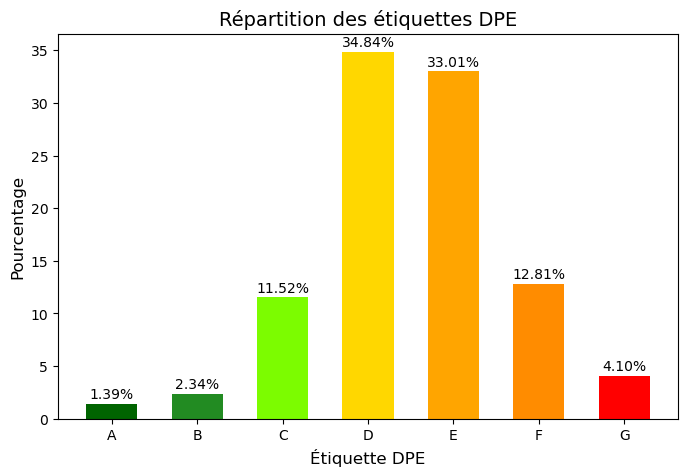

/tmp/ipykernel_10578/2682882188.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match3_filtre101["N°_département_(BAN)"] = match3_filtre101["N°_département_(BAN)"].astype(int).astype(str).str.zfill(2)


Répartition des DPE par département :
 Etiquette_DPE            A      B      C      D      E      F     G
N°_département_(BAN)                                               
10                     NaN  0.34%  1.37% 32.42% 41.98% 16.38% 7.51%
11                   2.15%  1.61% 22.04% 52.15% 17.20%  4.30% 0.54%
12                     NaN  1.06%  9.57% 28.19% 42.55% 15.96% 2.66%
13                   1.21% 10.66% 25.91% 41.57% 16.60%  3.10% 0.94%
14                   0.60%  0.24% 14.48% 23.16% 39.32% 16.04% 6.15%
...                    ...    ...    ...    ...    ...    ...   ...
91                   0.52%  0.97%  8.35% 29.06% 38.71% 15.66% 6.73%
92                   1.09%  1.05% 10.71% 25.69% 37.60% 18.78% 5.08%
93                   0.24%  2.07% 12.84% 26.72% 33.11% 18.75% 6.27%
94                   0.40%  1.14% 10.16% 28.31% 37.67% 17.47% 4.85%
95                   0.54%  0.93%  7.30% 29.50% 38.98% 17.47% 5.28%

[81 rows x 7 columns]
Département avec le plus de logements en A : 38
Départ

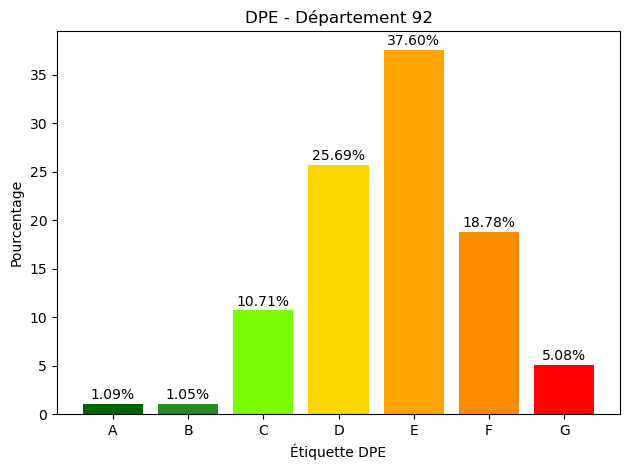

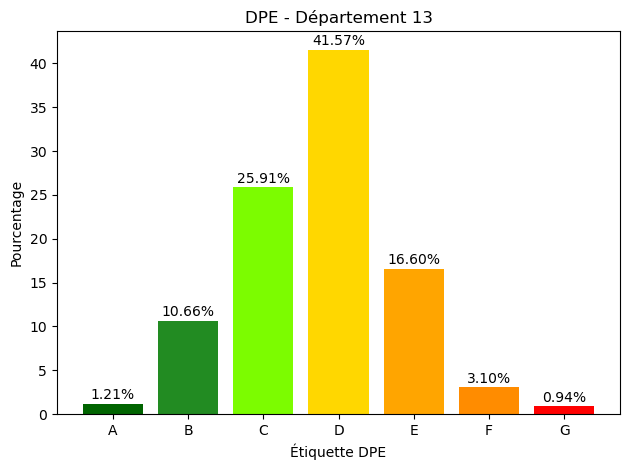

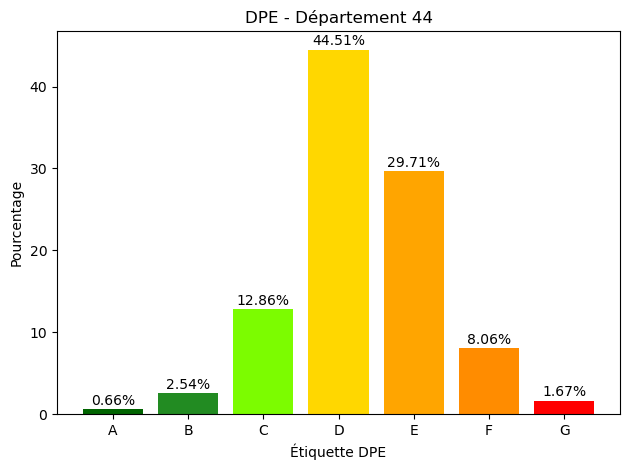


Types de bâtiments présents :
 Type_bâtiment
appartement    42965
maison         16387
immeuble         199
Name: count, dtype: int64


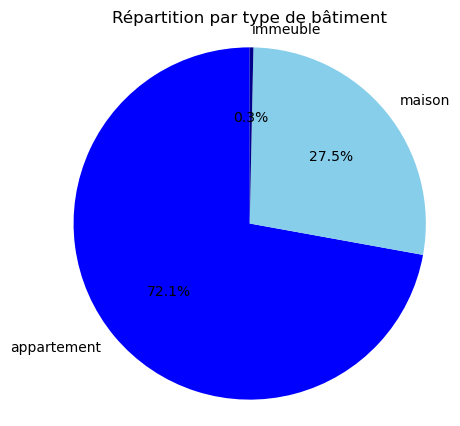

Pourcentage d'étiquettes DPE par type de bâtiment :
 Etiquette_DPE     A     B      C      D      E      F     G
Type_bâtiment                                              
appartement   1.37% 2.30% 12.30% 35.47% 33.78% 11.95% 2.83%
immeuble      5.03% 3.02% 16.58% 36.68% 29.15%  7.54% 2.01%
maison        1.39% 2.42%  9.43% 33.16% 31.02% 15.12% 7.44%
Type de bâtiment avec le plus de logements en A : appartement
Type de bâtiment avec le plus de logements en E : appartement


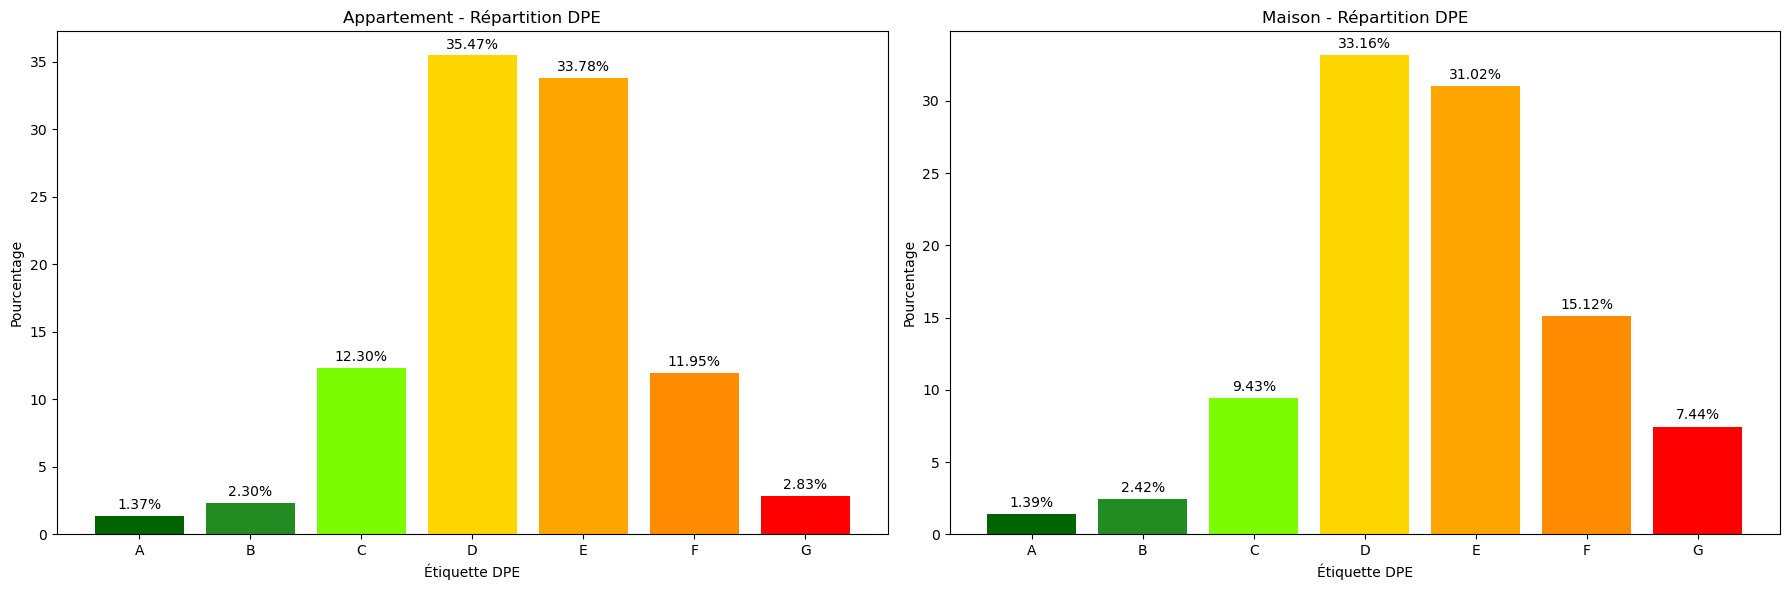

0       150000.00%
1       150000.00%
2       360500.00%
3        85000.00%
4        85000.00%
           ...    
59546   199000.00%
59547   246000.00%
59548   244150.00%
59549   170000.00%
59550    87000.00%
Name: valeur_fonciere, Length: 59551, dtype: float64
Moyenne : 295,970.18 €
Écart type : 1,398,741.90 €
Variance : 1,956,478,898,324.14 €²


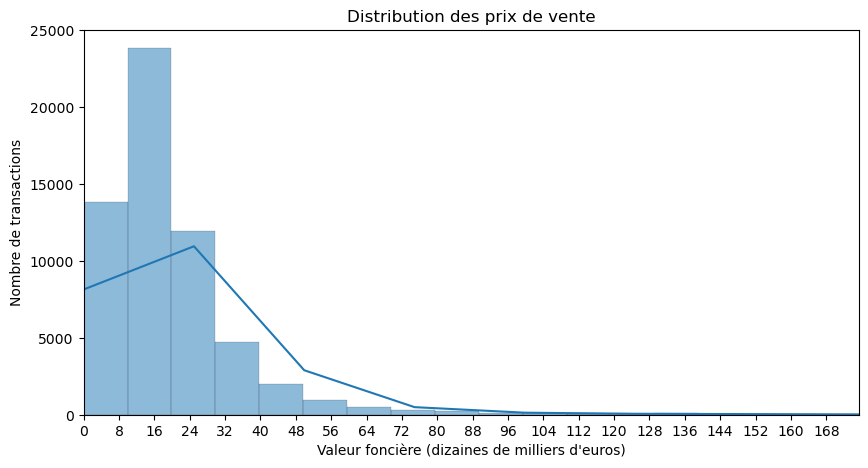

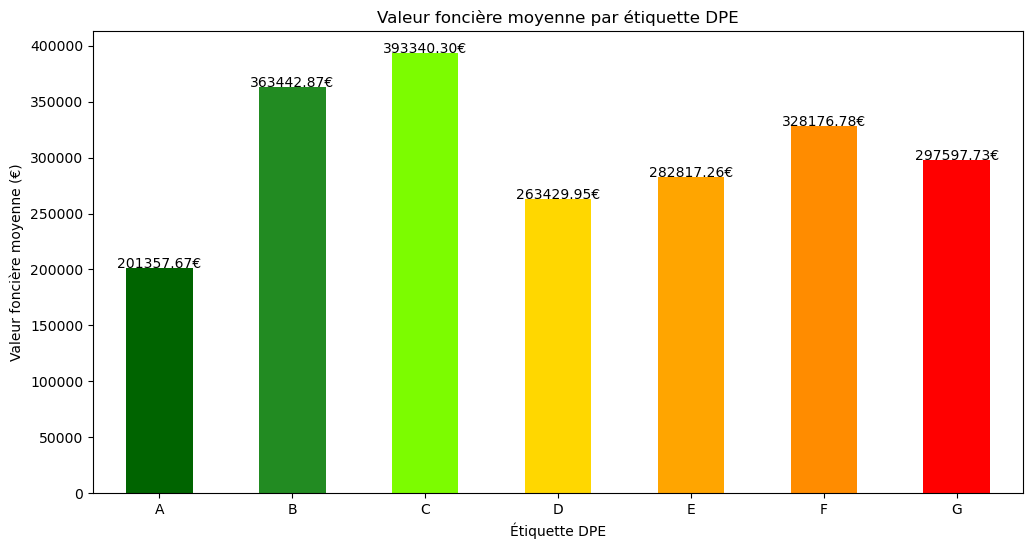

In [41]:
analyser_match(df2019)

Nombre de lignes : 70942
Nombre total de NaN : 1248490
Top 10 colonnes avec le plus de NaN :
 ancien_code_commune             70942
ancien_id_parcelle              70942
ancien_nom_commune              70942
numero_volume                   70942
lot5_surface_carrez             70929
lot4_surface_carrez             70876
lot5_numero                     70824
nature_culture_speciale         70645
code_nature_culture_speciale    70645
lot4_numero                     70527
dtype: int64


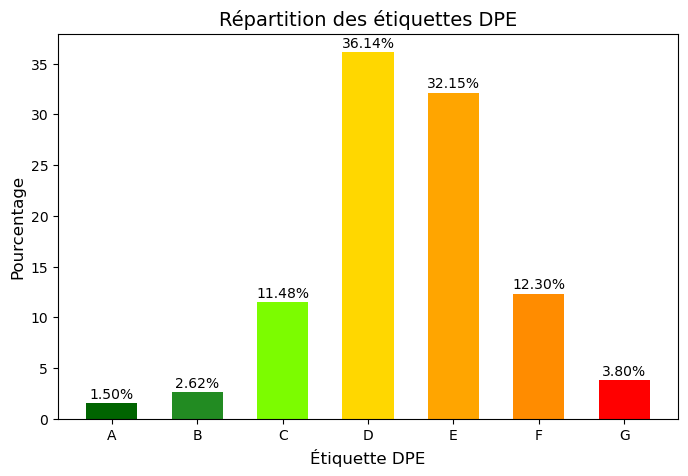

/tmp/ipykernel_10578/2682882188.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match3_filtre101["N°_département_(BAN)"] = match3_filtre101["N°_département_(BAN)"].astype(int).astype(str).str.zfill(2)


Répartition des DPE par département :
 Etiquette_DPE            A     B      C      D      E      F     G
N°_département_(BAN)                                              
10                     NaN 2.17%  5.26% 32.20% 38.39% 16.72% 5.26%
11                   0.81% 2.42% 18.95% 55.65% 17.74%  4.03% 0.40%
12                     NaN   NaN  5.91% 34.41% 42.47% 14.52% 2.69%
13                   3.22% 7.13% 29.11% 41.77% 14.38%  3.68% 0.69%
14                   1.18% 0.75%  9.97% 24.87% 38.26% 19.51% 5.47%
...                    ...   ...    ...    ...    ...    ...   ...
91                   0.36% 0.67%  7.74% 27.19% 39.58% 18.89% 5.57%
92                   0.29% 4.28%  9.50% 27.23% 37.94% 16.03% 4.73%
93                   0.16% 7.28%  8.37% 28.48% 30.87% 19.08% 5.76%
94                   0.39% 6.40% 14.32% 29.54% 30.97% 14.88% 3.50%
95                   1.23% 0.34%  7.86% 30.42% 41.56% 14.15% 4.44%

[81 rows x 7 columns]
Département avec le plus de logements en A : 38
Département avec le

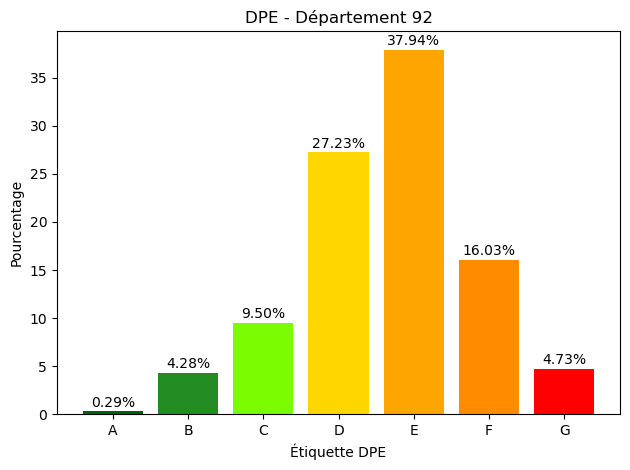

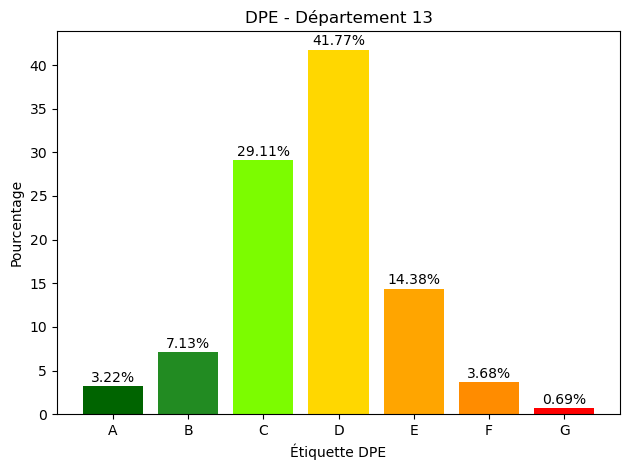

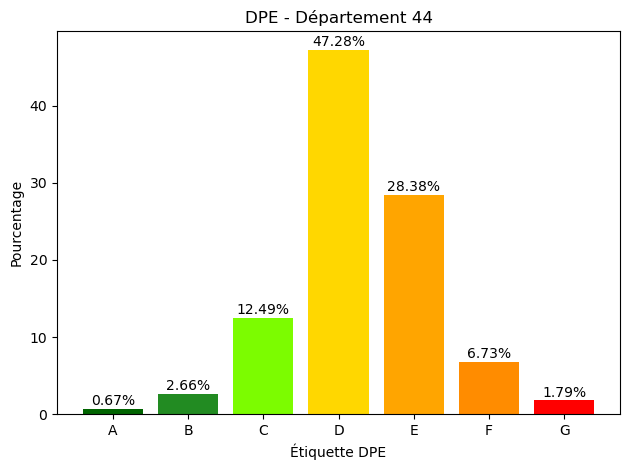


Types de bâtiments présents :
 Type_bâtiment
appartement    51302
maison         19421
immeuble         219
Name: count, dtype: int64


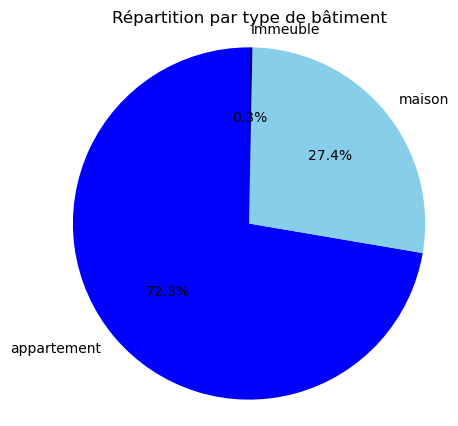

Pourcentage d'étiquettes DPE par type de bâtiment :
 Etiquette_DPE     A     B      C      D      E      F     G
Type_bâtiment                                              
appartement   1.42% 2.61% 11.91% 36.94% 32.88% 11.68% 2.57%
immeuble      5.02% 4.11% 16.89% 32.88% 25.57% 10.96% 4.57%
maison        1.67% 2.64% 10.30% 34.07% 30.30% 13.95% 7.07%
Type de bâtiment avec le plus de logements en A : appartement
Type de bâtiment avec le plus de logements en E : appartement


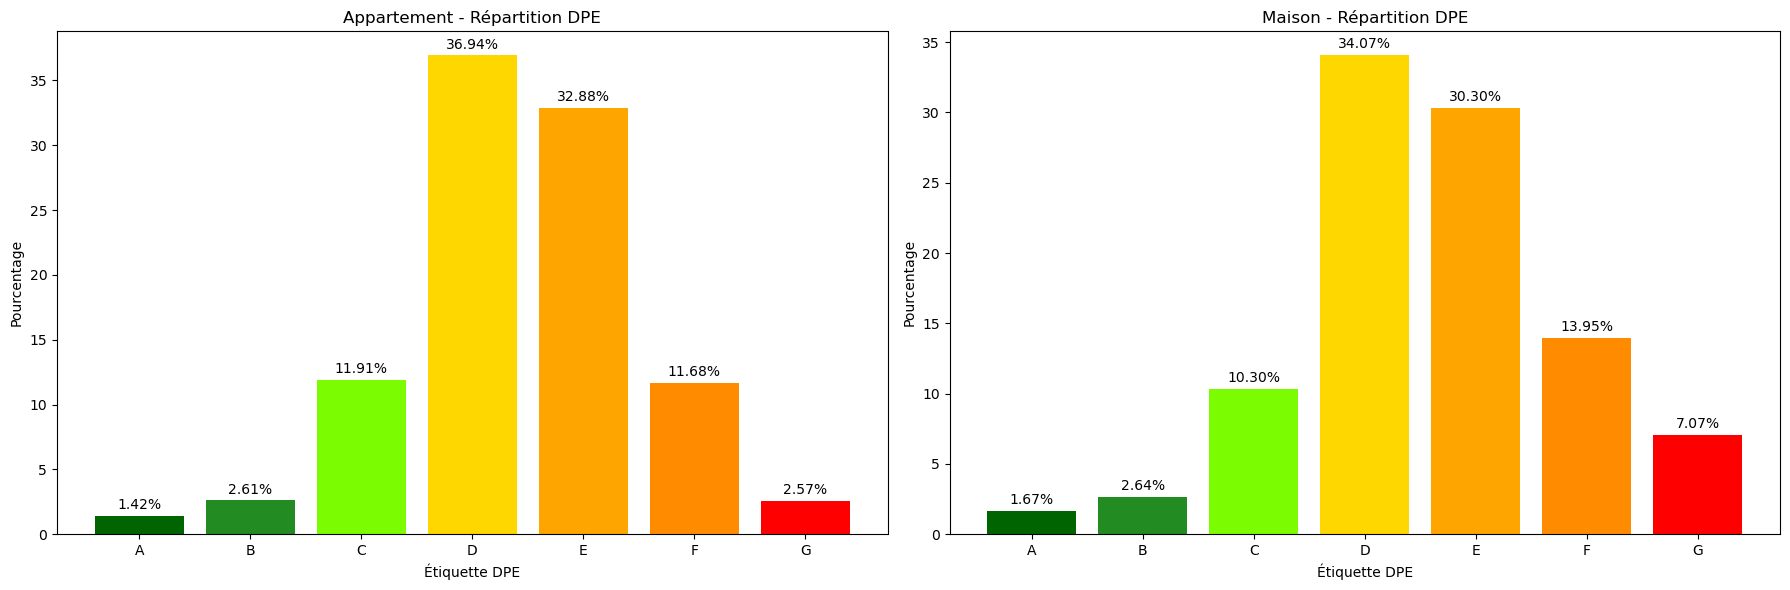

0        77000.00%
1        75000.00%
2       249000.00%
3       101000.00%
4        85000.00%
           ...    
70937   280000.00%
70938   160000.00%
70939   207000.00%
70940   151000.00%
70941    96000.00%
Name: valeur_fonciere, Length: 70942, dtype: float64
Moyenne : 307,713.44 €
Écart type : 1,357,509.55 €
Variance : 1,842,832,172,398.25 €²


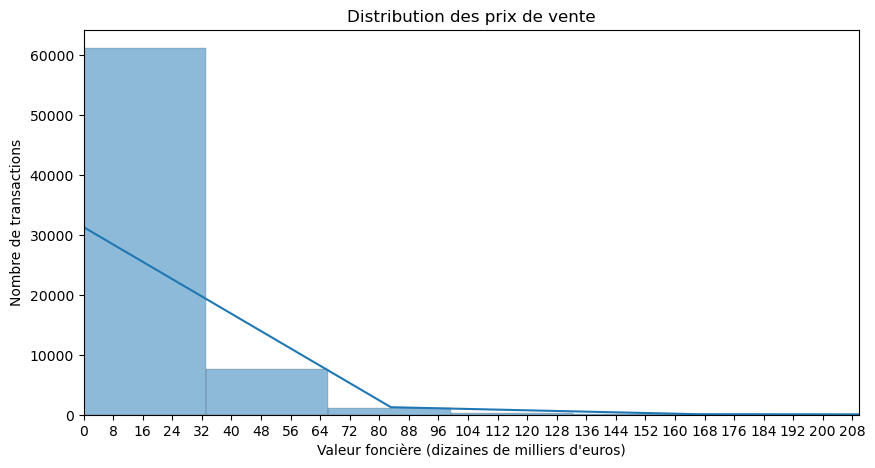

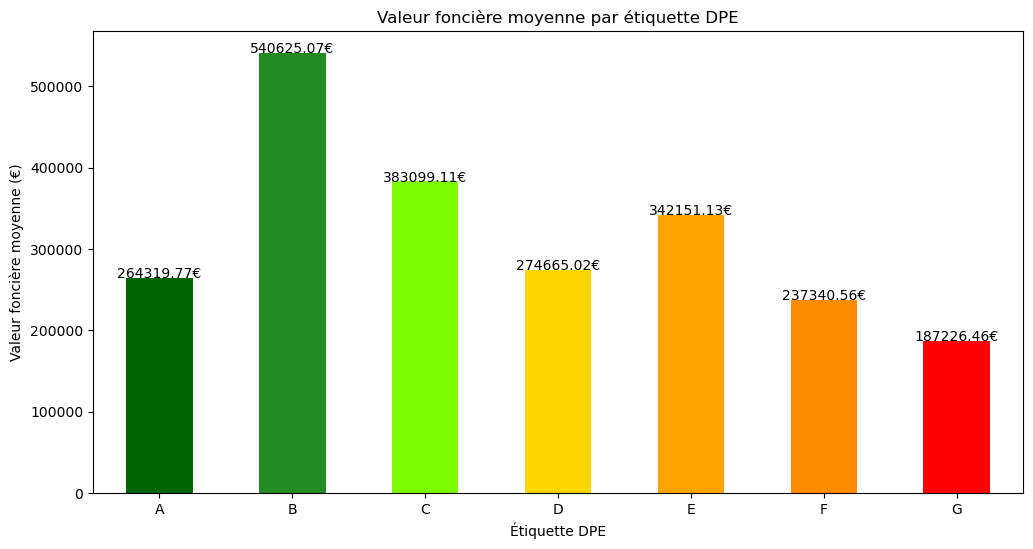

In [42]:
analyser_match(df2020)

## **Base 2021**

Nombre de lignes : 109421
Nombre total de NaN : 1926378
Top 10 colonnes avec le plus de NaN :
 ancien_code_commune             109421
ancien_id_parcelle              109421
ancien_nom_commune              109421
numero_volume                   109421
lot5_surface_carrez             109391
lot4_surface_carrez             109324
lot5_numero                     109230
nature_culture_speciale         109021
code_nature_culture_speciale    109021
lot4_numero                     108765
dtype: int64


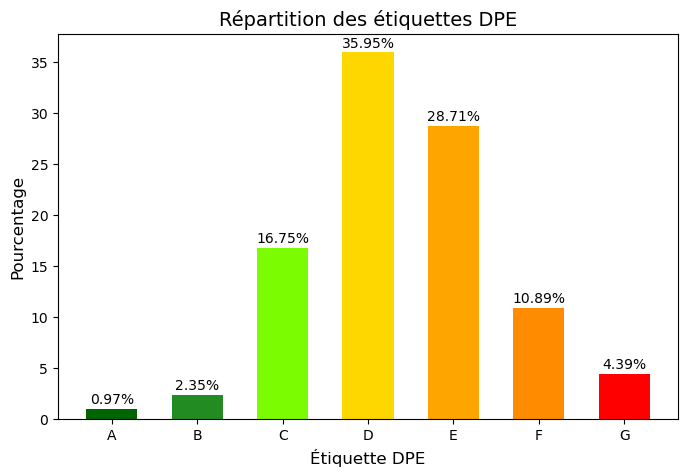

/tmp/ipykernel_10578/2682882188.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match3_filtre101["N°_département_(BAN)"] = match3_filtre101["N°_département_(BAN)"].astype(int).astype(str).str.zfill(2)


Répartition des DPE par département :
 Etiquette_DPE            A     B      C      D      E      F     G
N°_département_(BAN)                                              
10                   0.33% 0.83%  8.99% 33.28% 36.94% 13.31% 6.32%
11                   1.70% 4.73% 35.23% 40.34% 13.45%  3.79% 0.76%
12                     NaN 0.36% 13.14% 33.21% 35.04% 13.50% 4.74%
13                   3.44% 6.73% 36.43% 34.09% 14.19%  4.02% 1.10%
14                   0.52% 0.84% 12.40% 28.75% 34.04% 16.99% 6.46%
...                    ...   ...    ...    ...    ...    ...   ...
91                   0.14% 0.71%  9.55% 32.75% 37.40% 14.30% 5.15%
92                   0.21% 3.08%  9.08% 30.83% 34.25% 15.10% 7.46%
93                   0.42% 1.80% 14.47% 27.36% 31.89% 16.77% 7.29%
94                   0.17% 1.30% 10.97% 28.48% 35.95% 16.86% 6.27%
95                   1.74% 0.33% 10.13% 34.07% 35.72% 13.20% 4.81%

[81 rows x 7 columns]
Département avec le plus de logements en A : 38
Département avec le

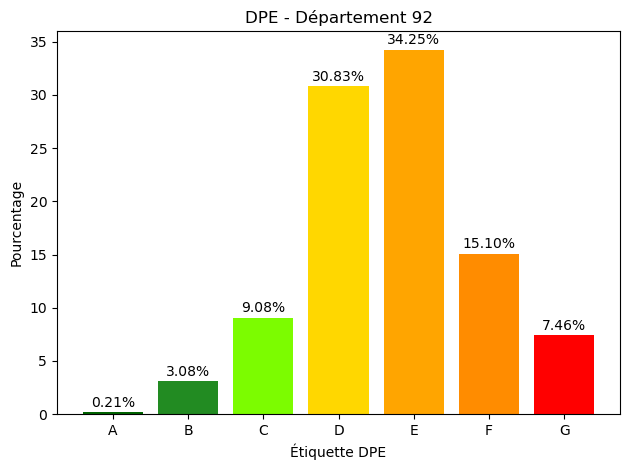

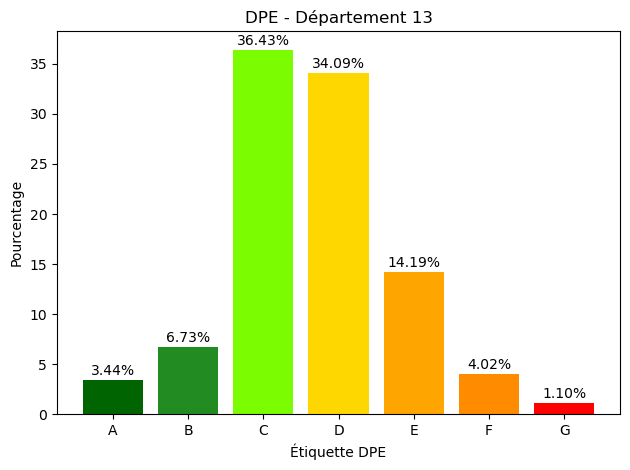

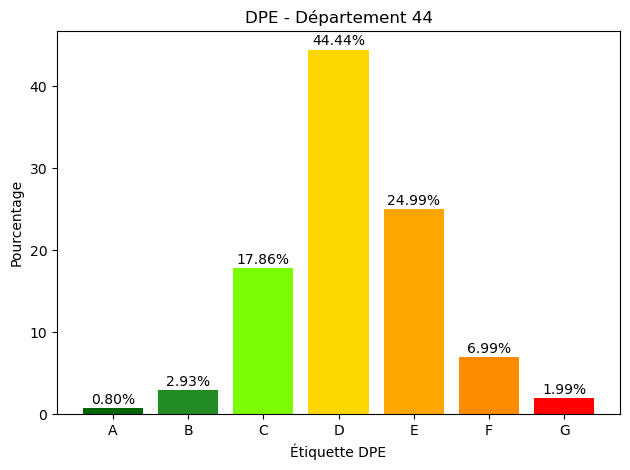


Types de bâtiments présents :
 Type_bâtiment
appartement    78937
maison         30303
immeuble         181
Name: count, dtype: int64


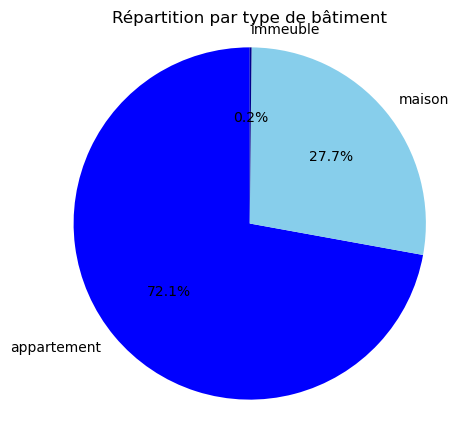

Pourcentage d'étiquettes DPE par type de bâtiment :
 Etiquette_DPE     A      B      C      D      E      F     G
Type_bâtiment                                               
appartement   0.77%  2.00% 17.75% 36.93% 29.07% 10.07% 3.41%
immeuble      6.63% 10.50% 13.26% 26.52% 28.73%  8.29% 6.08%
maison        1.45%  3.20% 14.16% 33.45% 27.78% 13.04% 6.92%
Type de bâtiment avec le plus de logements en A : appartement
Type de bâtiment avec le plus de logements en E : appartement


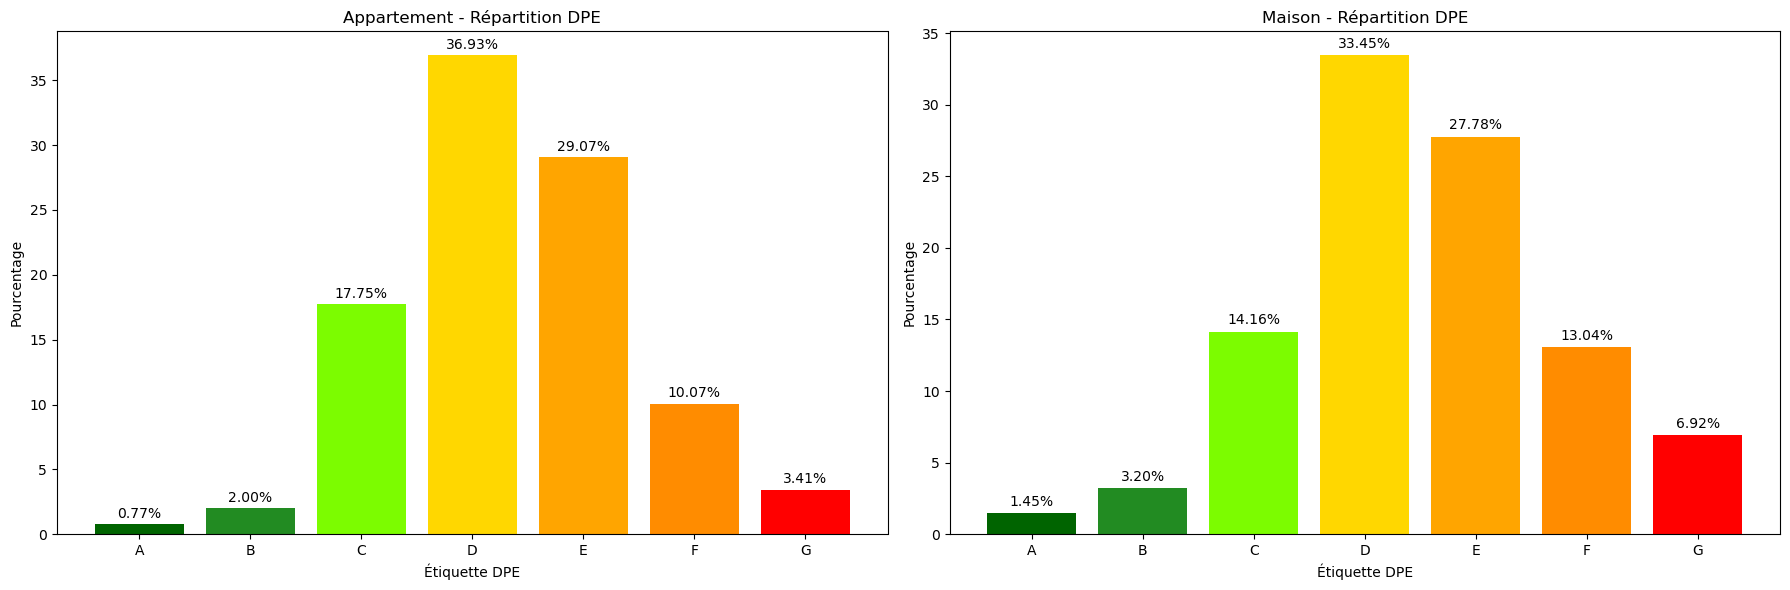

0        128000.00%
1         94000.00%
2         92500.00%
3         94000.00%
4         82000.00%
            ...    
109416   289800.00%
109417   114900.00%
109418    72000.00%
109419    72000.00%
109420   211000.00%
Name: valeur_fonciere, Length: 109421, dtype: float64
Moyenne : 604,658.75 €
Écart type : 8,295,745.08 €
Variance : 68,819,386,385,977.13 €²


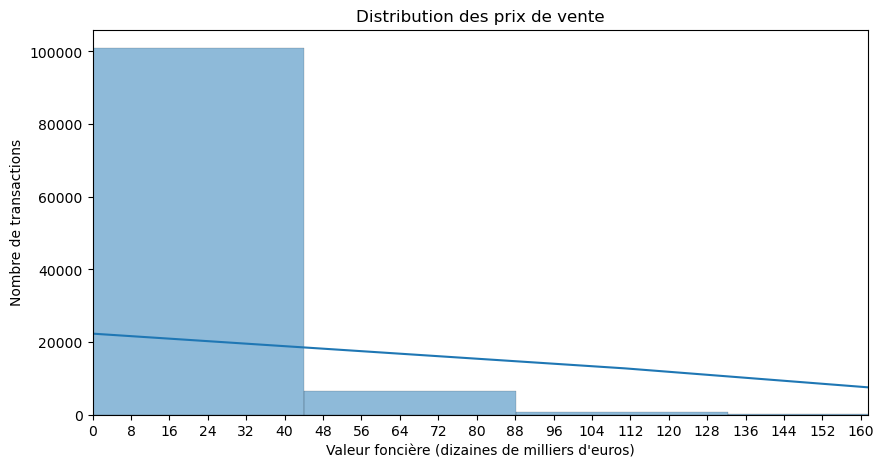

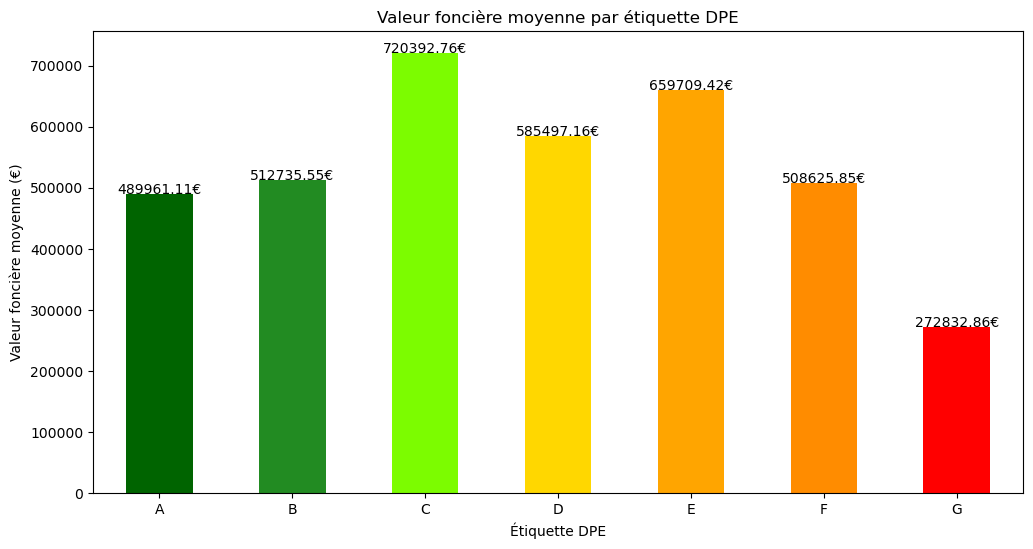

In [43]:
analyser_match(df2021)

## **Base 2022**

Nombre de lignes : 175491
Nombre total de NaN : 3123617
Top 10 colonnes avec le plus de NaN :
 ancien_id_parcelle              175491
numero_volume                   175491
ancien_nom_commune              175488
ancien_code_commune             175488
lot5_surface_carrez             175437
lot4_surface_carrez             175317
lot5_numero                     175137
nature_culture_speciale         174718
code_nature_culture_speciale    174718
lot3_surface_carrez             174355
dtype: int64


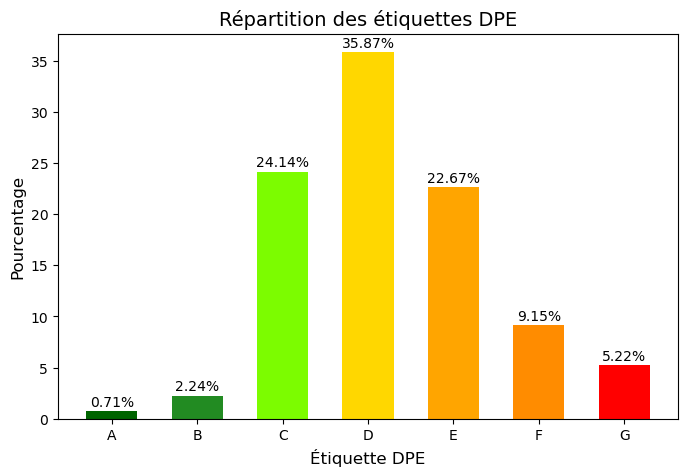

/tmp/ipykernel_10578/2682882188.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match3_filtre101["N°_département_(BAN)"] = match3_filtre101["N°_département_(BAN)"].astype(int).astype(str).str.zfill(2)


Répartition des DPE par département :
 Etiquette_DPE            A     B      C      D      E      F      G
N°_département_(BAN)                                               
10                   0.31% 1.14% 11.98% 36.47% 27.69% 14.77%  7.64%
11                   3.58% 7.45% 40.00% 31.32% 12.55%  3.96%  1.13%
12                   0.53% 1.58% 20.60% 41.55% 21.48% 10.04%  4.23%
13                   3.74% 9.47% 44.97% 26.84% 11.01%  3.02%  0.95%
14                   0.40% 1.36% 15.72% 35.55% 29.38% 11.35%  6.24%
...                    ...   ...    ...    ...    ...    ...    ...
91                   0.21% 1.11% 22.13% 36.69% 25.66%  9.82%  4.36%
92                   0.06% 0.91% 14.97% 30.23% 29.04% 13.95% 10.85%
93                   0.07% 1.33% 17.93% 30.91% 26.33% 13.14% 10.30%
94                   0.04% 1.41% 15.47% 31.87% 29.54% 12.94%  8.73%
95                   0.06% 1.04% 19.04% 38.14% 26.33%  9.54%  5.85%

[81 rows x 7 columns]
Département avec le plus de logements en A : 34
Départ

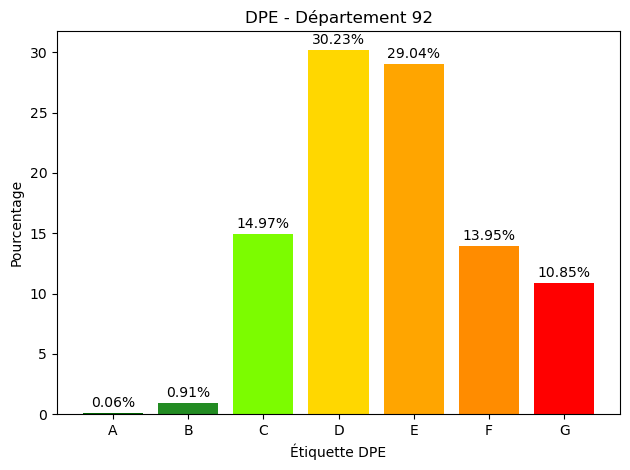

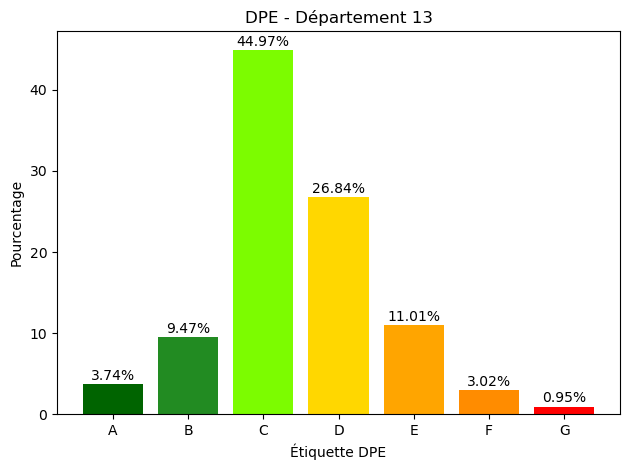

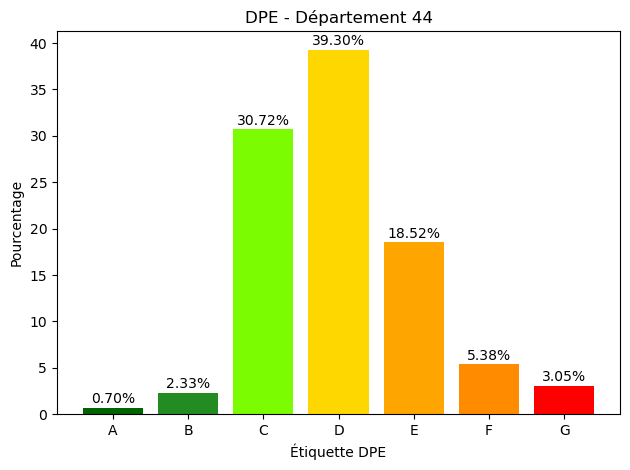


Types de bâtiments présents :
 Type_bâtiment
appartement    125562
maison          49929
Name: count, dtype: int64


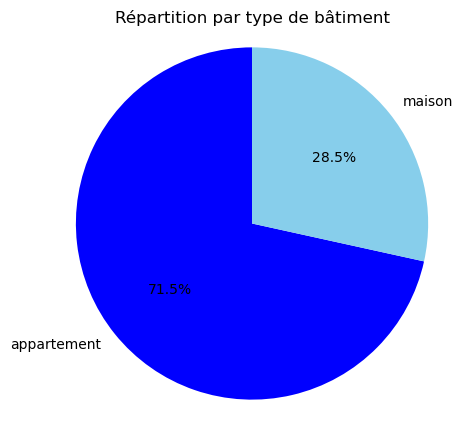

Pourcentage d'étiquettes DPE par type de bâtiment :
 Etiquette_DPE     A     B      C      D      E      F     G
Type_bâtiment                                              
appartement   0.24% 1.56% 25.42% 37.31% 22.87%  8.26% 4.36%
maison        1.91% 3.96% 20.93% 32.25% 22.16% 11.39% 7.40%
Type de bâtiment avec le plus de logements en A : maison
Type de bâtiment avec le plus de logements en E : appartement


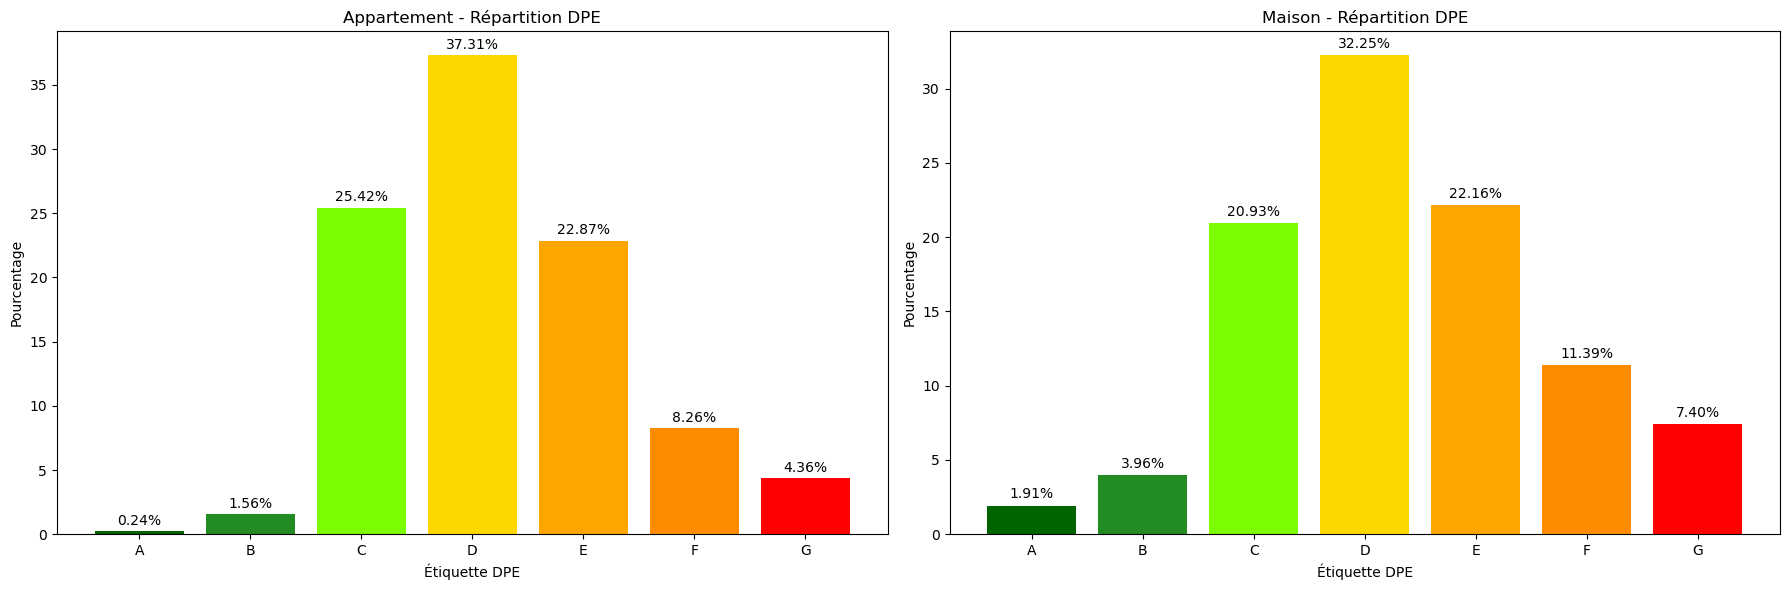

0        273700.00%
1        233000.00%
2        167000.00%
3        200250.00%
4        189900.00%
            ...    
175486   340200.00%
175487   192000.00%
175488   300000.00%
175489   415000.00%
175490   150000.00%
Name: valeur_fonciere, Length: 175491, dtype: float64
Moyenne : 1,657,885.09 €
Écart type : 20,856,824.84 €
Variance : 435,007,142,245,283.56 €²


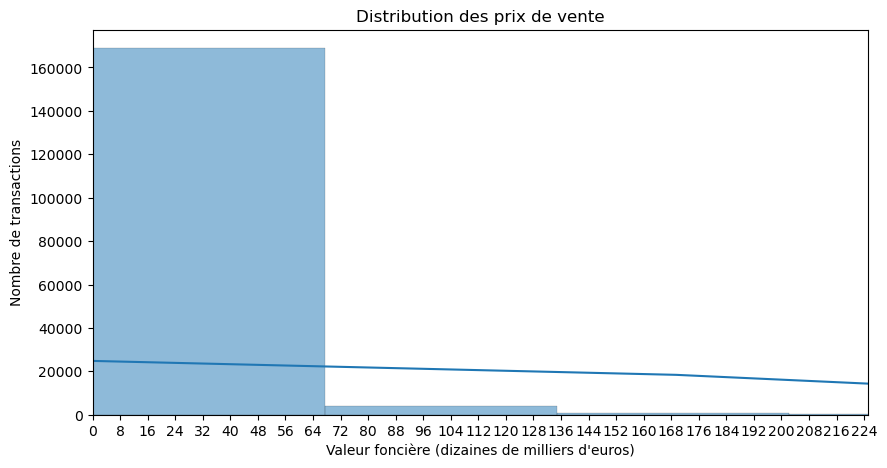

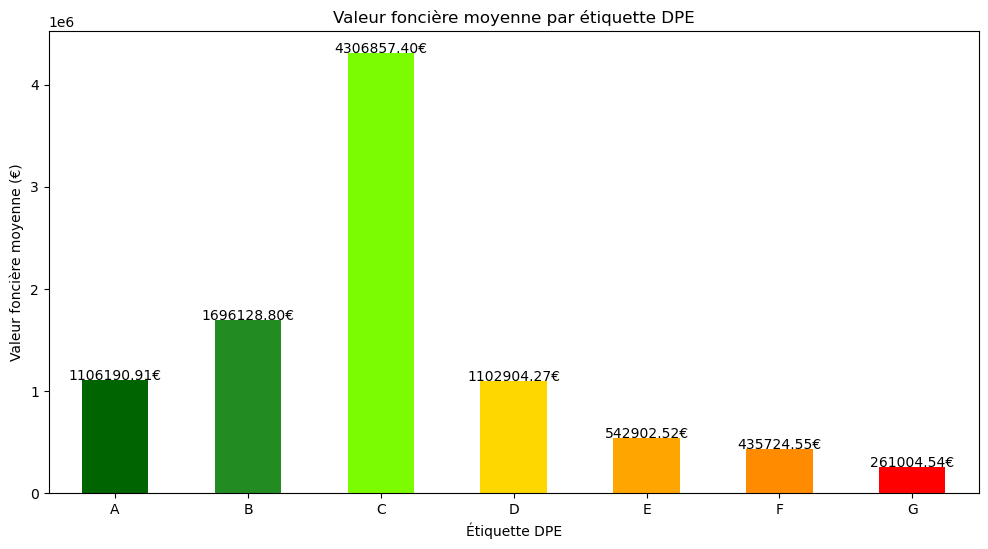

In [44]:
analyser_match(df2022)

Nombre de lignes : 97419
Nombre total de NaN : 1753968
Top 10 colonnes avec le plus de NaN :
 ancien_code_commune             97419
ancien_id_parcelle              97419
ancien_nom_commune              97419
numero_volume                   97419
lot5_surface_carrez             97398
lot4_surface_carrez             97330
lot5_numero                     97239
nature_culture_speciale         96879
code_nature_culture_speciale    96879
lot4_numero                     96817
dtype: int64


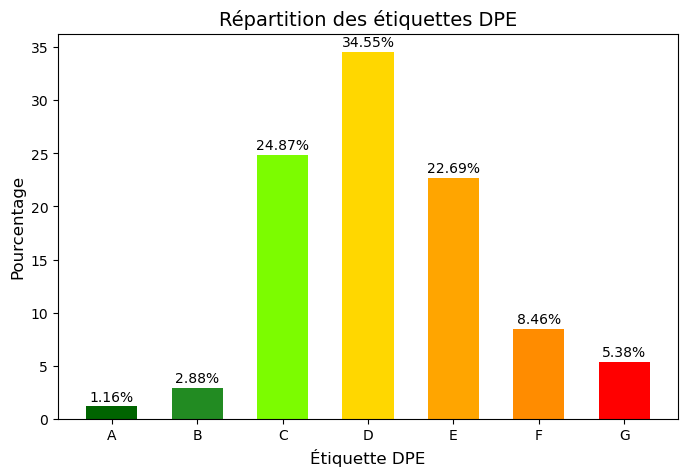

/tmp/ipykernel_10578/2682882188.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match3_filtre101["N°_département_(BAN)"] = match3_filtre101["N°_département_(BAN)"].astype(int).astype(str).str.zfill(2)


Répartition des DPE par département :
 Etiquette_DPE            A      B      C      D      E      F     G
N°_département_(BAN)                                               
10                   0.34%  1.84% 11.89% 38.53% 27.81% 10.89% 8.71%
11                   4.61%  7.88% 40.56% 31.05% 12.04%  2.82% 1.04%
12                   0.33%  2.67% 19.67% 41.00% 22.67%  9.33% 4.33%
13                   5.19% 11.89% 43.10% 24.98% 10.22%  3.51% 1.12%
14                   0.67%  2.29% 15.98% 33.51% 27.96% 10.50% 9.10%
...                    ...    ...    ...    ...    ...    ...   ...
91                   0.20%  3.09% 23.98% 35.69% 23.50%  7.89% 5.65%
92                   0.11%  0.94% 17.11% 29.65% 28.87% 13.68% 9.65%
93                   0.08%  1.31% 20.33% 29.75% 27.61% 11.38% 9.55%
94                   0.07%  2.43% 17.06% 31.07% 27.77% 11.86% 9.74%
95                   0.05%  0.98% 22.12% 36.90% 25.21%  9.12% 5.61%

[81 rows x 7 columns]
Département avec le plus de logements en A : 34
Départ

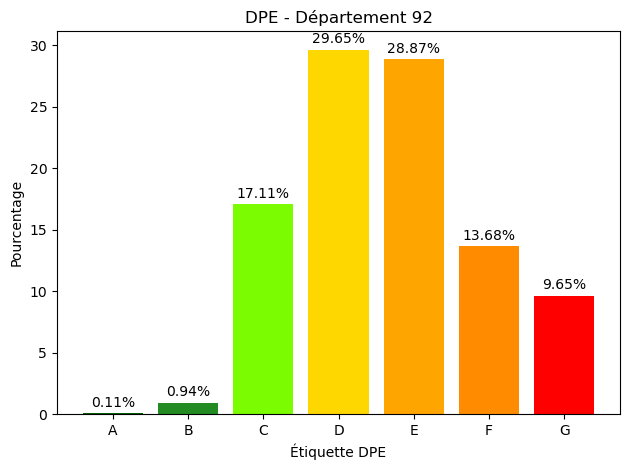

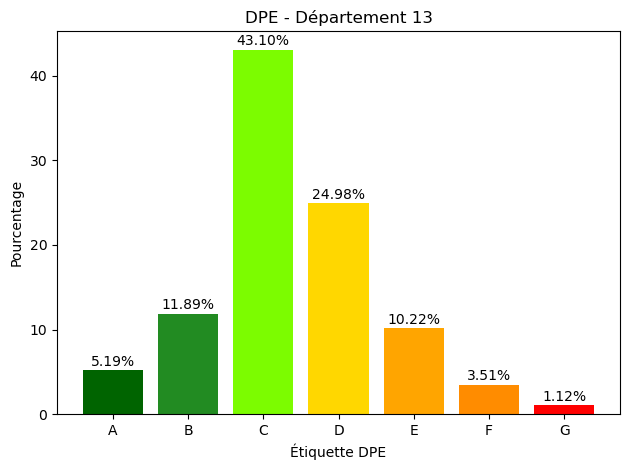

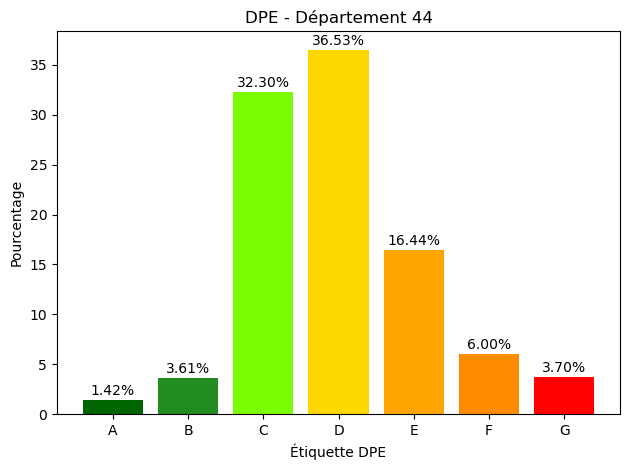


Types de bâtiments présents :
 Type_bâtiment
appartement    66039
maison         31380
Name: count, dtype: int64


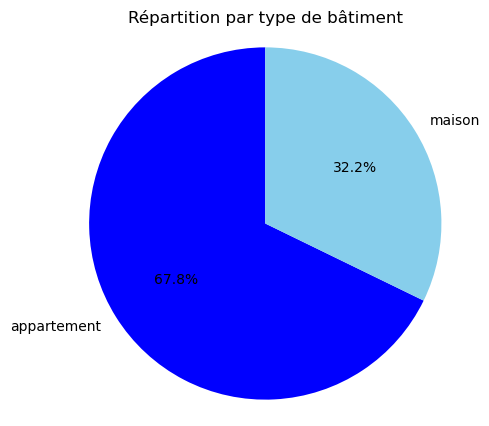

Pourcentage d'étiquettes DPE par type de bâtiment :
 Etiquette_DPE     A     B      C      D      E      F     G
Type_bâtiment                                              
appartement   0.34% 2.07% 27.33% 36.68% 21.94%  7.47% 4.16%
maison        2.90% 4.57% 19.68% 30.07% 24.27% 10.54% 7.95%
Type de bâtiment avec le plus de logements en A : maison
Type de bâtiment avec le plus de logements en E : appartement


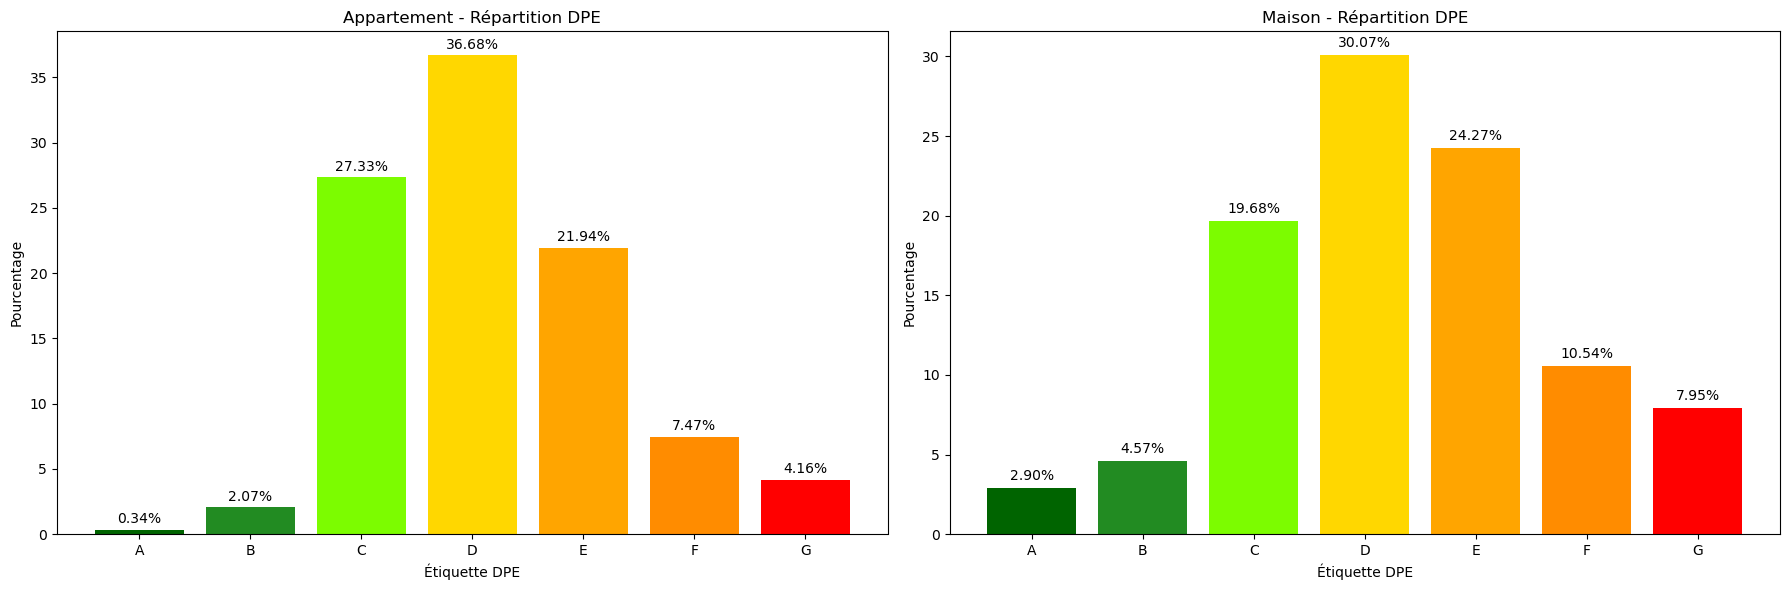

0       252500.00%
1       140000.00%
2       215500.00%
3       114625.00%
4        70000.00%
           ...    
97414    80000.00%
97415   160000.00%
97416   355000.00%
97417   470000.00%
97418   166000.00%
Name: valeur_fonciere, Length: 97419, dtype: float64
Moyenne : 262,481.64 €
Écart type : 725,761.34 €
Variance : 526,729,520,941.64 €²


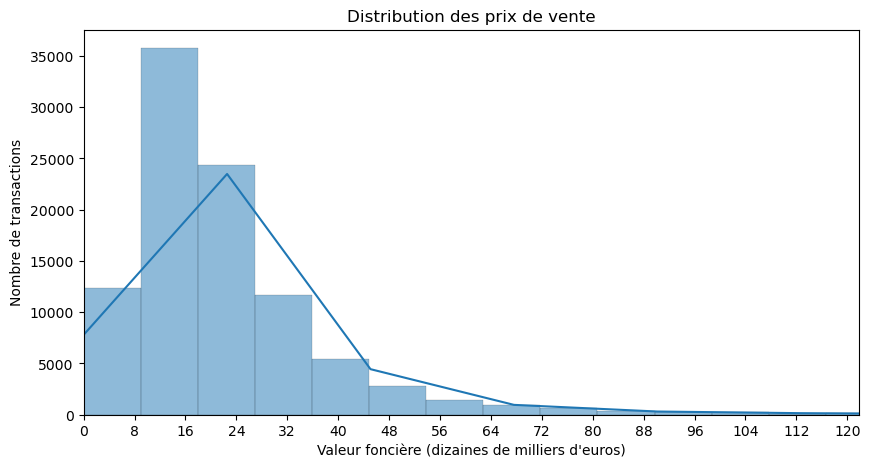

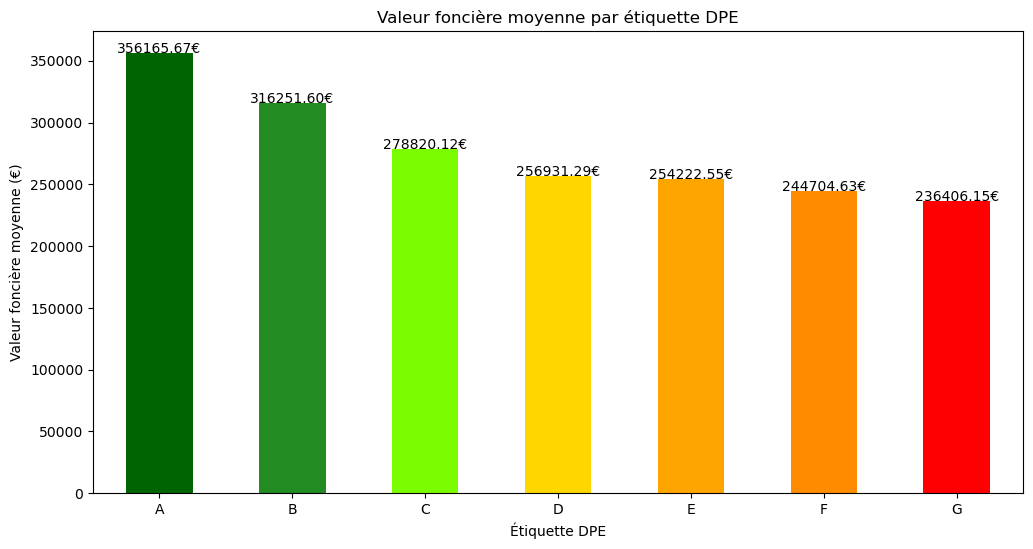

In [45]:
analyser_match(df2023)

Nombre de lignes : 512824
Nombre total de NaN : 9100476
Top 10 colonnes avec le plus de NaN :
 numero_volume                   512824
ancien_id_parcelle              512820
ancien_nom_commune              512817
ancien_code_commune             512817
lot5_surface_carrez             512689
lot4_surface_carrez             512352
lot5_numero                     511888
nature_culture_speciale         510571
code_nature_culture_speciale    510571
lot4_numero                     509707
dtype: int64


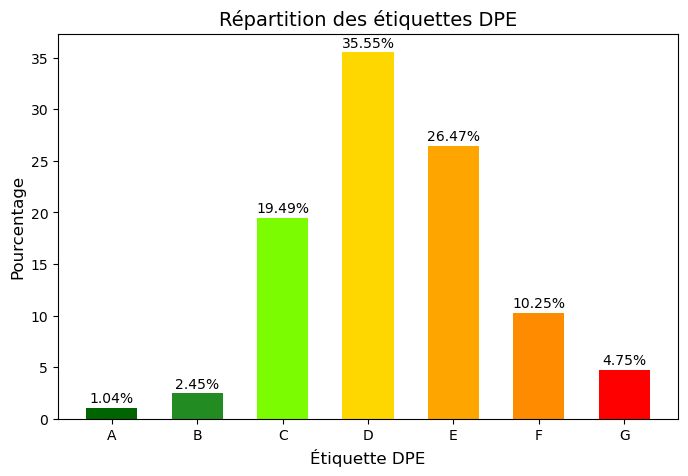

/tmp/ipykernel_10578/2682882188.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match3_filtre101["N°_département_(BAN)"] = match3_filtre101["N°_département_(BAN)"].astype(int).astype(str).str.zfill(2)


Répartition des DPE par département :
 Etiquette_DPE            A     B      C      D      E      F     G
N°_département_(BAN)                                              
10                   0.25% 1.26%  9.42% 35.30% 32.46% 14.02% 7.30%
11                   3.12% 6.16% 36.03% 36.70% 13.40%  3.67% 0.93%
12                   0.26% 1.32% 15.90% 37.40% 29.35% 11.81% 3.96%
13                   3.60% 9.18% 38.47% 31.72% 12.63%  3.43% 0.98%
14                   0.60% 1.22% 14.20% 31.01% 32.34% 13.93% 6.70%
...                    ...   ...    ...    ...    ...    ...   ...
91                   0.25% 1.32% 15.96% 33.32% 31.43% 12.48% 5.24%
92                   0.25% 1.81% 13.03% 29.30% 32.21% 14.95% 8.45%
93                   0.18% 2.36% 15.69% 29.09% 29.21% 15.09% 8.39%
94                   0.17% 2.32% 14.10% 30.28% 31.62% 14.32% 7.19%
95                   0.62% 0.78% 14.90% 34.95% 31.64% 11.79% 5.33%

[81 rows x 7 columns]
Département avec le plus de logements en A : 34
Département avec le

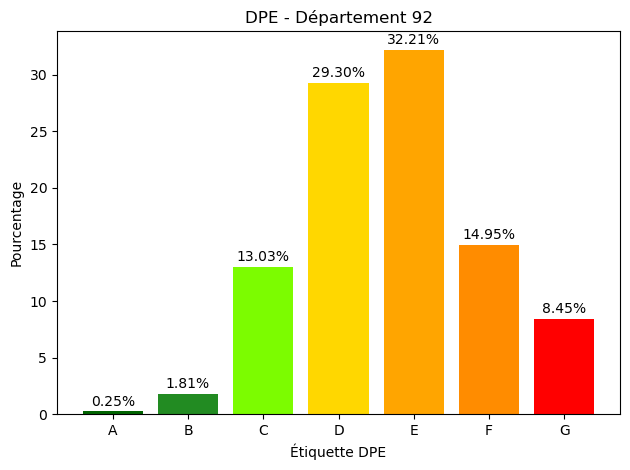

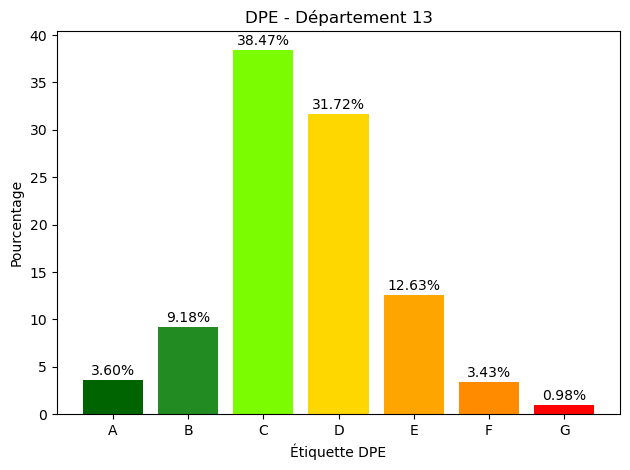

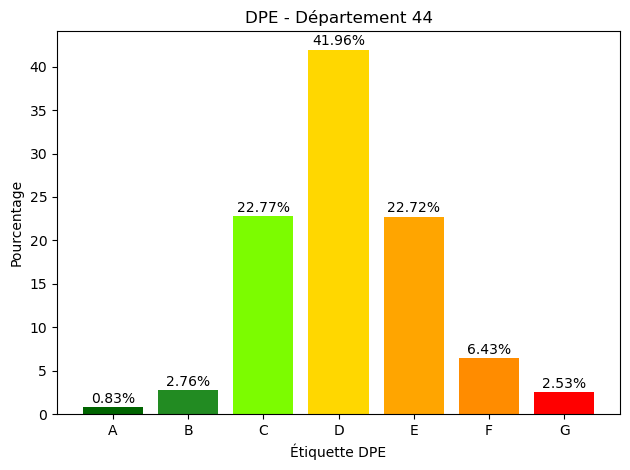


Types de bâtiments présents :
 Type_bâtiment
appartement    364805
maison         147420
immeuble          599
Name: count, dtype: int64


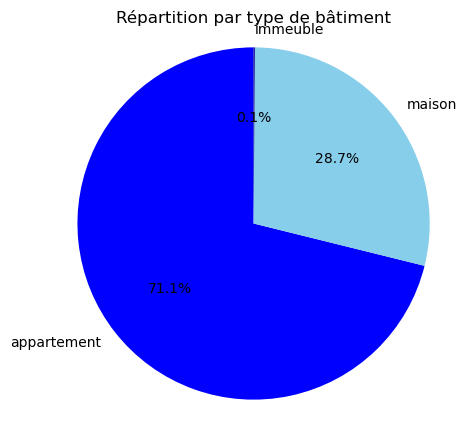

Pourcentage d'étiquettes DPE par type de bâtiment :
 Etiquette_DPE     A     B      C      D      E      F     G
Type_bâtiment                                              
appartement   0.67% 1.98% 20.66% 36.84% 26.73%  9.42% 3.68%
immeuble      5.51% 5.68% 15.69% 32.22% 27.71%  9.02% 4.17%
maison        1.94% 3.59% 16.59% 32.37% 25.82% 12.30% 7.38%
Type de bâtiment avec le plus de logements en A : maison
Type de bâtiment avec le plus de logements en E : appartement


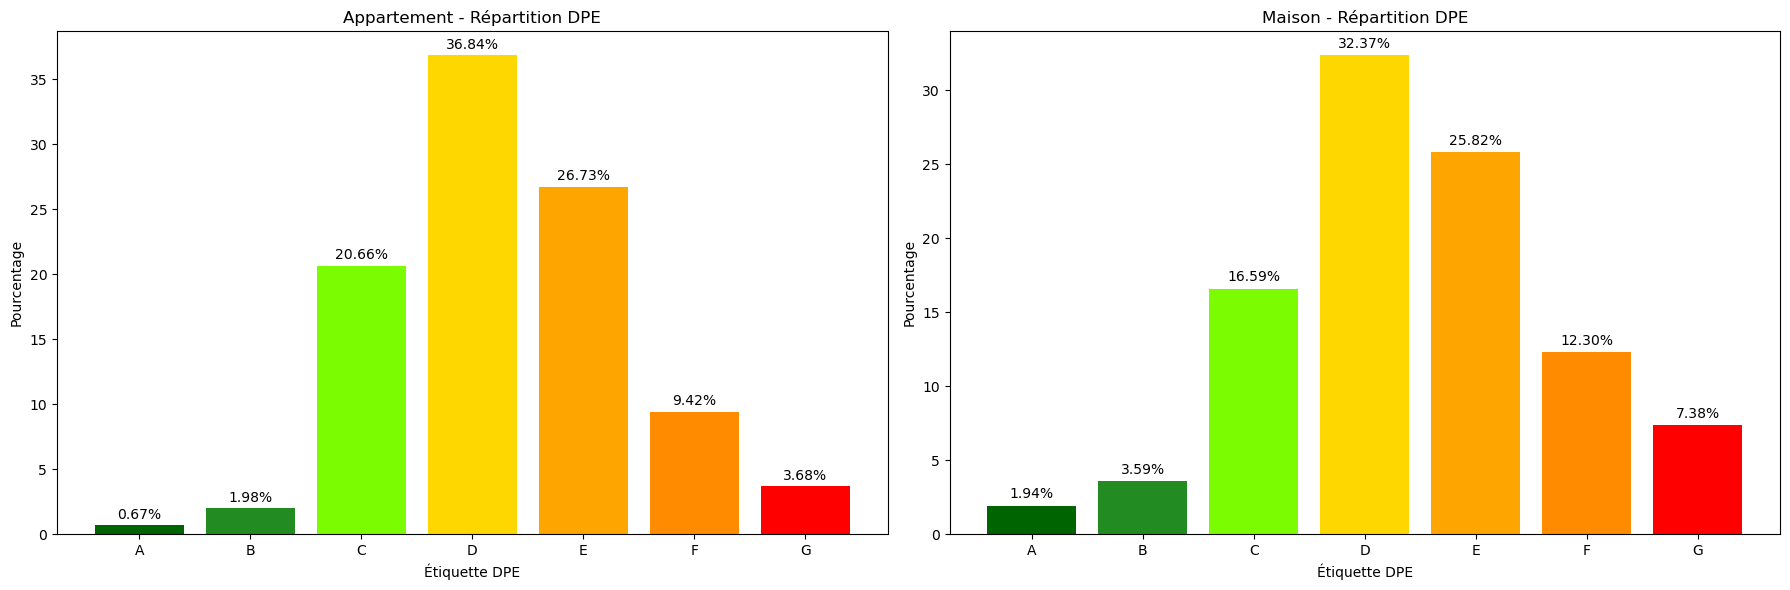

0        150000.00%
1        150000.00%
2        360500.00%
3         85000.00%
4         85000.00%
            ...    
512819    80000.00%
512820   160000.00%
512821   355000.00%
512822   470000.00%
512823   166000.00%
Name: valeur_fonciere, Length: 512824, dtype: float64
Moyenne : 823,162.28 €
Écart type : 12,826,061.47 €
Variance : 164,507,852,826,442.06 €²


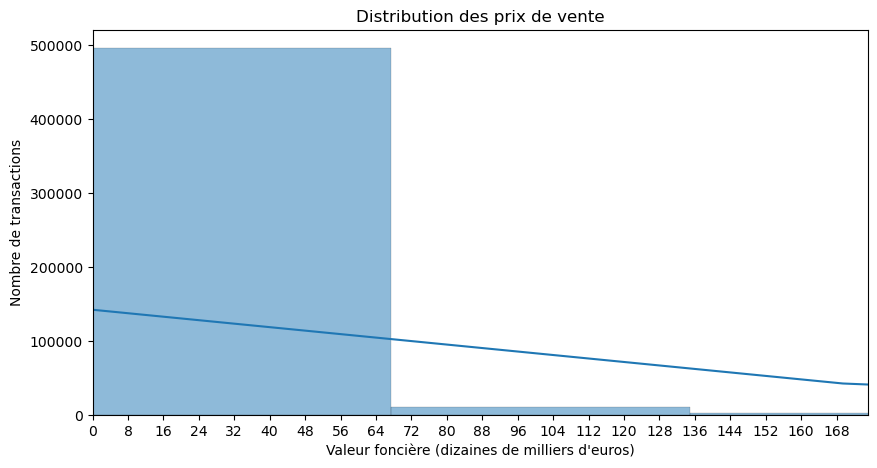

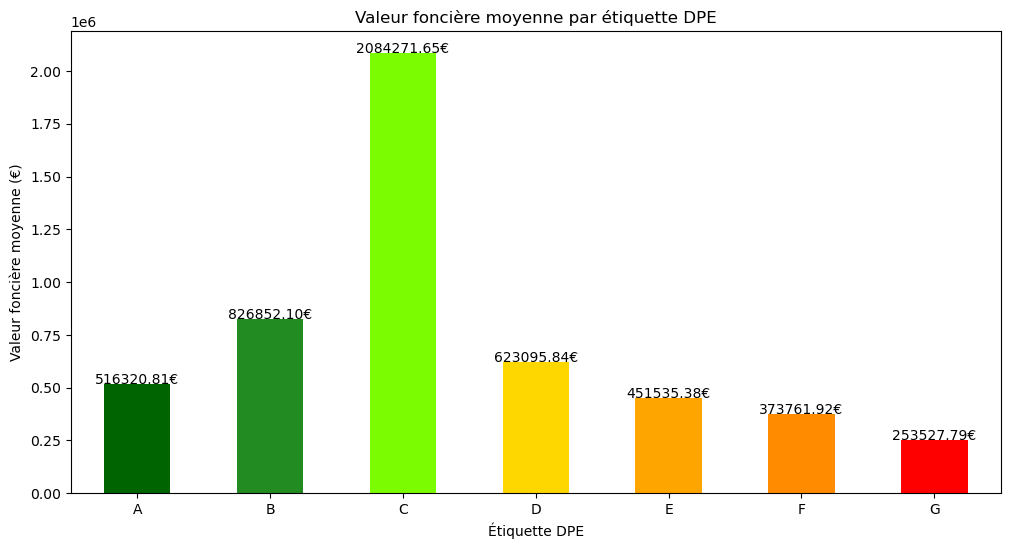

In [46]:
analyser_match(df)

In [53]:
# Liste des départements possibles (de 01 à 95)
departements_possibles = [str(i).zfill(2) for i in range(1, 96)]

# Identifier les départements présents dans ton DataFrame
departements_present = df["N°_département_(BAN)"].dropna().unique()

# Identifier les départements manquants
departements_manquants = list(set(departements_possibles) - set(departements_present))
print("Départements sans observations : ", departements_manquants)


Départements sans observations :  ['94', '71', '75', '19', '43', '53', '38', '22', '12', '87', '62', '34', '15', '18', '25', '39', '49', '65', '03', '54', '77', '61', '37', '26', '04', '66', '82', '60', '02', '40', '81', '13', '52', '10', '83', '95', '33', '46', '59', '79', '88', '69', '01', '42', '20', '09', '14', '44', '07', '27', '05', '67', '89', '80', '64', '57', '72', '47', '74', '30', '92', '11', '85', '56', '68', '90', '16', '06', '76', '32', '36', '70', '50', '63', '91', '21', '55', '28', '84', '31', '45', '41', '29', '78', '93', '24', '08', '86', '17', '23', '51', '73', '48', '58', '35']
